# Agent-Based Model on Cat Behavior

### In our project we decided to create 4 total cats with several different traits ranging from hunger levels to personality traits
### Based on the traits each cat has will determine their interactions with each other, objects in the room, and people who walk in the room

In [2]:
from IPython.display import HTML
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time

To start here is a legend of all potential personality traits and needs our cats may have.

In [4]:
legend= {'Calm' : 'Very relaxed',
         'Clumsy' : 'Will tumble over and bump into things' ,
         'Shy' : 'Takes a while to warm up, might hide away' ,
         'Affectionate' : 'Loves cuddles' ,
         "Playful" : 'Wants to hunt and play' ,
         'Smart' : 'Learns quickly good at tricks' , 
         'Anxious' : 'Hides and paces around' , 
         'Angry' : 'Will hiss, growl, and bite' ,
         'Curious' : 'Adventurous and Engageful ' ,
         'Scared' : 'Will run away' ,
         'Energetic' : 'Will run around and play'} 

Because we want our interactions to be as random and organic as possible we will create a class that will help cat decisions!

In [6]:


class Cat:
    def __init__(self, name, personality, image_path):
        self.name = name
        self.personality = personality
        self.image_path = image_path
        self.activity = 'still'

        # physical needs
        self.sleep = 0
        self.hunger = 0
        self.potty = 0

        # position and motion
        self.x, self.y = random.randint(10, 140), random.randint(10, 140)
        self.speed = 0.5
        self.target = self.random_target()
        self.mood = "😐"

    def random_target(self):
        return (random.randint(10, 140), random.randint(10, 140))

    def update_traits(self):
        self.hunger += 1
        self.potty += 1
        self.sleep += 1

    def eat(self):
        self.hunger = 0
        self.potty += 2
        self.activity = "eat"

    def bed(self):
        self.sleep = max(0, self.sleep - 3)
        self.activity = "sleep"

    def play(self):
        self.hunger += 2
        self.sleep += 2
        self.potty += 1
        self.activity = "play"

    def bathroom(self):
        self.potty = 0
        self.activity = "bathroom"

    def action_choices(self):
        actions = {
            'eat': self.hunger,
            'sleep': self.sleep,
            'bathroom': self.potty,
            'play': self.personality.get('Playful', 1)
        }
        action = max(actions, key=actions.get)
        getattr(self, action)()

        

    def move_towards(self, target_x, target_y):
        dx = target_x - self.x
        dy = target_y - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 0:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
    def move(self):
        dx = self.target[0] - self.x
        dy = self.target[1] - self.y
        dist = (dx**2 + dy**2)**0.5
        if dist > 1:
            self.x += self.speed * dx / dist
            self.y += self.speed * dy / dist
            # Stay inside the plot area
            self.x = min(max(self.x, 0), 150)
            self.y = min(max(self.y, 0), 150)



    def roam(self):
        if self.mood == "😐":  # only roam if not interacting
            self.target = self.random_target()
    

    def distance_to(self, other):
        return ((self.x - other.x) ** 2 + (self.y - other.y) ** 2) ** 0.5

    def interact_with(self, other_cat):
        distance = self.distance_to(other_cat)
    
        if distance < 25:
            shy = self.personality.get("Shy", 0)
            affectionate = self.personality.get("Affectionate", 0)
    
            if shy >= 4:
                self.mood = "🙀"
                # Move away from the other cat
                dx = self.x - other_cat.x
                dy = self.y - other_cat.y
                self.target = (self.x + dx, self.y + dy)
    
            elif affectionate >= 4:
                self.mood = "😻"
                self.target = (other_cat.x, other_cat.y)
    
            else:
                self.mood = "😺"
        else:
            self.mood = "😐"


    def __repr__(self):
        return f'Cat({self.name}), traits: {self.personality}'


In [7]:
cats = [ 
    Cat('Tito', {
        'Playful': 5, 'Affectionate': 4, 'Shy': 5, 'Calm': 2,
        'Curious': 3, 'Smart': 1, 'Hunger': 3, 'Sleep': 3, 'Scared': 4
    }, "tito.png"),

    Cat('Tobi', {
        'Playful': 3, 'Affectionate': 4, 'Shy': 1, 'Calm': 4,
        'Curious': 5, 'Smart': 3, 'Hunger': 3, 'Sleep': 3, 'Scared': 1
    }, "tobi.png"),

    Cat('Dumpling', {
        'Playful': 4, 'Affectionate': 5, 'Shy': 2, 'Calm': 3,
        'Curious': 4, 'Smart': 4, 'Hunger': 2, 'Sleep': 4, 'Scared': 2
    }, "dumpling.png"),

    Cat('Jiji', {
        'Playful': 2, 'Affectionate': 2, 'Shy': 4, 'Calm': 5,
        'Curious': 1, 'Smart': 5, 'Hunger': 4, 'Sleep': 2, 'Scared': 5
    }, "jiji.png")
]
        

Here you can find out who our cats are and what their personality traits are!

The start of the simulation for the visualization.

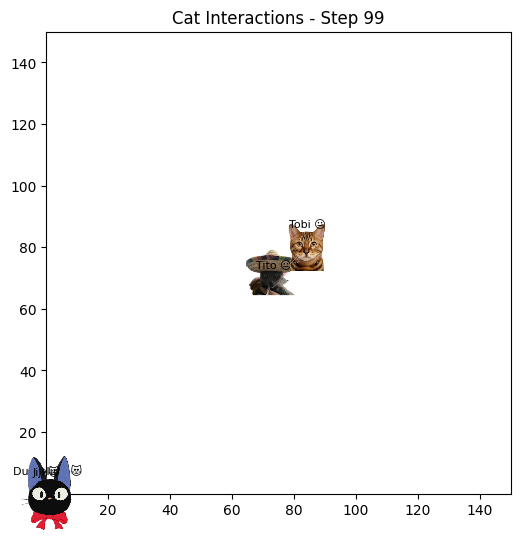

In [18]:
from IPython.display import display, clear_output
def imscatter(x, y, image_path, ax=None, zoom=0.25):
    if ax is None:
        ax = plt.gca()
    image = Image.open(image_path).convert("RGBA")
    image = np.asarray(image)
    im = OffsetImage(image, zoom=zoom)
    ab = AnnotationBbox(im, (x, y), frameon=False)
    ax.add_artist(ab)
    return ab
    
#Visualization
fig, ax = plt.subplots(figsize=(6, 6))

for step in range(100):
    ax.clear()
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 150)
    ax.set_title(f"Cat Interactions - Step {step}")

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            cats[i].interact_with(cats[j])
            cats[j].interact_with(cats[i])  # mutual!
    
    # Now move + roam based on updated moods
    for cat in cats:
        if cat.mood == "😐":
            cat.roam()
        cat.move()

        imscatter(cat.x, cat.y, cat.image_path, ax=ax, zoom=0.25)
        ax.text(cat.x, cat.y + 6, f"{cat.name} {cat.mood}", ha='center', fontsize=8)

    for i in range(len(cats)):
        for j in range(i + 1, len(cats)):
            if cats[i].distance_to(cats[j]) < 30:
                ax.plot([cats[i].x, cats[j].x], [cats[i].y, cats[j].y], 'r--', alpha=0.3)
    plt.draw()
    clear_output(wait=True)
    display(fig)
    time.sleep(0.1)
    
plt.close()


FileNotFoundError: [Errno 2] No such file or directory: 'Main Code/tito.png'

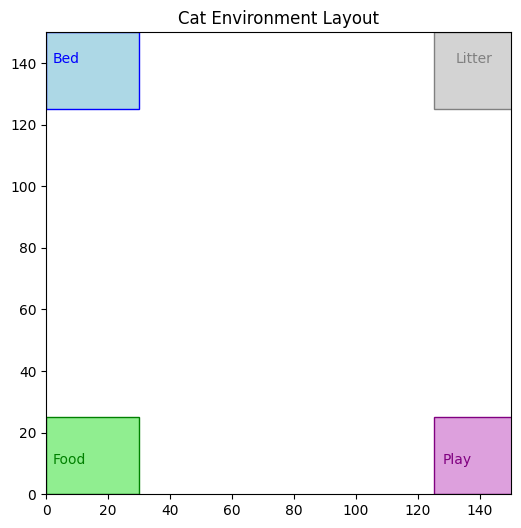

In [72]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg

# Load images
def get_cat_image(path, zoom=0.15):
    return OffsetImage(mpimg.imread(path), zoom=zoom)

# Starting bed center position
start_x, start_y = 15, 137

# Define cats
cat_data = [
    ("Tito", "tito.png"),
    ("Tobi", "tobi.png"),
    ("Dumpling", "dumpling.png"),
    ("Jiji", "jiji.png")
]

# Plot environment
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, 150)
ax.set_ylim(0, 150)
ax.set_title("Cat Environment Layout")

# Environment boxes
ax.add_patch(patches.Rectangle((0, 125), 30, 25, edgecolor='blue', facecolor='lightblue'))
ax.text(2, 140, "Bed", fontsize=10, color='blue')

ax.add_patch(patches.Rectangle((125, 125), 30, 25, edgecolor='gray', facecolor='lightgray'))
ax.text(132, 140, "Litter", fontsize=10, color='gray')

ax.add_patch(patches.Rectangle((0, 0), 30, 25, edgecolor='green', facecolor='lightgreen'))
ax.text(2, 10, "Food", fontsize=10, color='green')

ax.add_patch(patches.Rectangle((125, 0), 30, 25, edgecolor='purple', facecolor='plum'))
ax.text(128, 10, "Play", fontsize=10, color='purple')

# Place each cat slightly offset from bed center to avoid overlap
offsets = [(0, 0), (5, 5), (-5, 5), (5, -5)]

for (name, img_file), (dx, dy) in zip(cat_data, offsets):
    img = get_cat_image(f"Main Code/{img_file}")
    ab = AnnotationBbox(img, (start_x + dx, start_y + dy), frameon=False)
    ax.add_artist(ab)
    ax.text(start_x + dx + 1, start_y + dy + 1, name, fontsize=8)

plt.show()
